In [22]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tflearn


#from PIL import Image
from scipy.misc import imread, imresize
from sklearn.cross_validation import train_test_split
from matplotlib import ticker
%matplotlib inline


### Preprocessing the images

In [46]:
TRAIN_DIR = './data/train/'
TEST_DIR = './data/test1/'

ROWS = 64
COLS = 64
CHANNELS = 3
IMREAD_MODE = 'RGB'

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:1000] + train_cats[:1000]
random.shuffle(train_images)
test_images =  test_images[:25]

def read_image(file_path):
    img = imread(file_path) #IMREAD_GRAYSCALE)
    return imresize(img, (ROWS, COLS))


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

#train = prep_data(train_images)
#test = prep_data(test_images)
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)
        
X, X_test, Y, Y_test = train_test_split(train_images, labels, test_size=0.1, random_state=42)
X = prep_data(X)
X_test = prep_data(X_test)

Y = to_categorical(Y, 2)
Y_test = to_categorical(Y_test, 2)
print("Train shape: {}".format(X.shape))
print("Test shape: {}".format(X_test.shape))

Processed 0 of 1800
Processed 250 of 1800
Processed 500 of 1800
Processed 750 of 1800
Processed 1000 of 1800
Processed 1250 of 1800
Processed 1500 of 1800
Processed 1750 of 1800
Processed 0 of 200
Train shape: (1800, 3, 64, 64)
Test shape: (200, 3, 64, 64)


### Generating the Labels
(1) = Dog
(2) = Cat

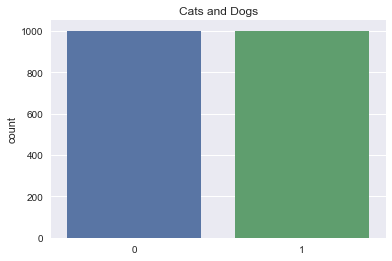

In [45]:
from tflearn.data_utils import to_categorical

labels = np.array(labels)
#Y = np.array(Y)

sns.countplot(labels)
sns.plt.title('Cats and Dogs')

In [47]:
Y.shape

(1800, 2)

### Showing some of the data

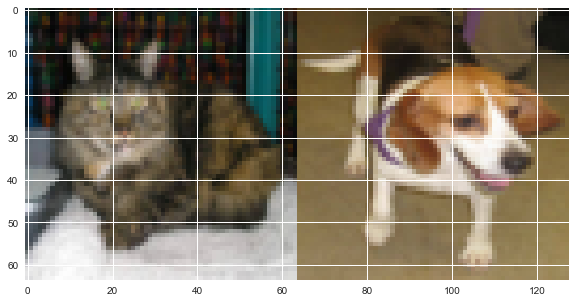

In [48]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()

show_cats_and_dogs(420)

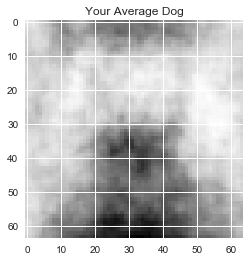

In [51]:
dog_avg = np.array([dog[0].T for i, dog in enumerate(X) if labels[i]==1]).mean(axis=0)
plt.imshow(dog_avg)
plt.title('Your Average Dog')

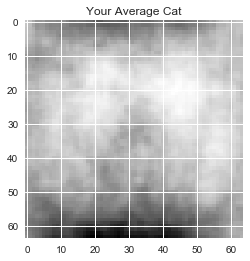

In [52]:
cat_avg = np.array([cat[0].T for i, cat in enumerate(X) if labels[i]==0]).mean(axis=0)
plt.imshow(cat_avg)
plt.title('Your Average Cat')

In [53]:
X.shape

(1800, 3, 64, 64)

In [54]:
Y.shape

(1800, 2)

### Assembling the model

In [63]:
def catdog(learn_rate=0.00001):
    x = tflearn.input_data(shape=[None, 3, 64, 64], name='input')
    
    x = tflearn.conv_2d(x, 64, 3, activation='relu', scope='conv1_1')
    x = tflearn.conv_2d(x, 64, 3, activation='relu', scope='conv1_2')
    x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool1')
    
    x = tflearn.conv_2d(x, 128, 3, activation='relu', scope='conv2_1')
    x = tflearn.conv_2d(x, 128, 3, activation='relu', scope='conv2_2')
    x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool2')
    
    x = tflearn.conv_2d(x, 256, 3, activation='relu', scope='conv3_1')
    x = tflearn.conv_2d(x, 256, 3, activation='relu', scope='conv3_2')
    x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool3')
    
    x = tflearn.conv_2d(x, 512, 3, activation='relu', scope='conv4_1')
    x = tflearn.conv_2d(x, 512, 3, activation='relu', scope='conv4_2')
    x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool4')
    
    x = tflearn.conv_2d(x, 512, 3, activation='relu', scope='conv5_1')
    x = tflearn.conv_2d(x, 512, 3, activation='relu', scope='conv5_2')
    x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool5')
    
    x = tflearn.fully_connected(x, 4096, activation='relu', scope='fc6')
    x = tflearn.dropout(x, 0.5, name='dropout1')
    
    x = tflearn.fully_connected(x, 4096, activation='relu', scope='fc7')
    x = tflearn.dropout(x, 0.5, name='dropout2')
    
    x = tflearn.fully_connected(x, 2, activation='softmax', scope='fc8')
    
    x = tflearn.regression(x, optimizer='adam', loss='categorical_crossentropy', learning_rate=learn_rate)
    
    return x # x == network

In [64]:
from tflearn.metrics import Accuracy

In [65]:
learn_rate = 0.00001
batch_size = 10
epochs = 5

### Building the model

In [66]:
import tensorflow as tf
tf.reset_default_graph()

net = catdog(learn_rate)
acc = Accuracy(name='Accuracy')

model = tflearn.DNN(net, checkpoint_path='model_cat_dog_6.tflearn', tensorboard_dir='./tmp/tflearn_logs/', max_checkpoints=3, tensorboard_verbose=3)

In [67]:
X.shape

(1800, 3, 64, 64)

In [68]:
Y.shape

(1800, 2)

In [ ]:
X_test.shape

(200, 3, 64, 64)

### Fitting the model

In [ ]:
model.fit(X, Y, batch_size=batch_size, n_epoch=epochs, shuffle=True)
#predictions = model.predict(test, verbose=0)


Training Step: 155  | total loss: 0.69317 | time: 193.534s
| Adam | epoch: 001 | loss: 0.69317 -- iter: 1550/1800


### Making Predictions

In [ ]:
predictions = model.predict(X_test, verbose=0)

In [ ]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()